In [ ]:
# Calling convert_taco_to_yolo.py, to create train/val/test folders, and fill out data/recycle.yaml

In [2]:
from pathlib import Path
import os, sys, json, random, shutil
import pandas as pd

In [2]:
# Detect repo root (works whether you start in repo/ or repo/notebooks/)
CWD = Path().resolve()
if (CWD / ".git").exists() and (CWD / "data").exists():
    REPO_ROOT = CWD
elif (CWD.parent / ".git").exists() and (CWD.parent / "data").exists():
    REPO_ROOT = CWD.parent
else:
    raise SystemExit("❌ Could not find repo root. Open the notebook from the repo or repo/notebooks.")

In [3]:
print("Repo root:", REPO_ROOT)

Repo root: C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO


In [4]:
RAW_DIR       = REPO_ROOT / "data" / "raw" / "taco"
COCO_JSON     = RAW_DIR / "annotations.json"
IMAGES_DIR    = RAW_DIR / "images"
CLASS_MAP     = REPO_ROOT / "data" / "scripts" / "class_map.json"
CONVERTER     = REPO_ROOT / "data" / "scripts" / "convert_taco_to_yolo.py"
PROC_IMG_ALL  = REPO_ROOT / "data" / "processed" / "images" / "all"
PROC_LBL_ALL  = REPO_ROOT / "data" / "processed" / "labels" / "all"
NAMES_TXT     = REPO_ROOT / "data" / "processed" / "names.txt"
RECYCLE_YAML  = REPO_ROOT / "data" / "recycle.yaml"

for p in [COCO_JSON, IMAGES_DIR, CLASS_MAP, CONVERTER, NAMES_TXT]:
    print(("✅" if p.exists() else "❌"), p)

✅ C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\data\raw\taco\annotations.json
✅ C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\data\raw\taco\images
✅ C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\data\scripts\class_map.json
✅ C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\data\scripts\convert_taco_to_yolo.py
❌ C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\data\processed\names.txt


In [5]:
cmd = f'python -u "{REPO_ROOT / "data" / "scripts" / "convert_taco_to_yolo.py"}" ' \
      f'--coco "{COCO_JSON}" ' \
      f'--images "{IMAGES_DIR}" ' \
      f'--class_map "{CLASS_MAP}" ' \
      f'--out_images "{PROC_IMG_ALL}" ' \
      f'--out_labels "{PROC_LBL_ALL}" ' \
      f'--names_out "{NAMES_TXT}"'
print("Running:\n", cmd)
rc = os.system(cmd)
print("Exit code:", rc)
print("names.txt exists?", NAMES_TXT.exists())
if NAMES_TXT.exists():
    print(NAMES_TXT.read_text())


Running:
 python -u "C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\data\scripts\convert_taco_to_yolo.py" --coco "C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\data\raw\taco\annotations.json" --images "C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\data\raw\taco\images" --class_map "C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\data\scripts\class_map.json" --out_images "C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\data\processed\images\all" --out_labels "C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\data\processed\labels\all" --names_out "C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\data\processed\names.txt"
Exit code: 0
names.txt exists? True
plastic_bottle
glass_bottle
metal_can
other_plastic
plastic_film


In [6]:
random.seed(123)

IMG_EXTS = {".jpg", ".jpeg", ".png"}
all_imgs = sorted([p for p in PROC_IMG_ALL.rglob("*") if p.suffix.lower() in IMG_EXTS])

def lbl_for(img_path: Path) -> Path:
    return PROC_LBL_ALL / (img_path.with_suffix(".txt").name)

# Keep only images that have at least one mapped label
paired = [(im, lbl_for(im)) for im in all_imgs if lbl_for(im).exists()]
print(f"Total converted pairs: {len(paired)}")

random.shuffle(paired)
n = len(paired)
n_train = int(0.8*n)
n_val   = int(0.1*n)

splits = {
    "train": paired[:n_train],
    "val":   paired[n_train:n_train+n_val],
    "test":  paired[n_train+n_val:]
}
for split, items in splits.items():
    print(split, len(items))

# Write split folders
for split, items in splits.items():
    out_i = REPO_ROOT / "data" / "processed" / "images" / split
    out_l = REPO_ROOT / "data" / "processed" / "labels" / split
    if out_i.exists(): shutil.rmtree(out_i)
    if out_l.exists(): shutil.rmtree(out_l)
    out_i.mkdir(parents=True, exist_ok=True)
    out_l.mkdir(parents=True, exist_ok=True)

    for im, lb in items:
        shutil.copy2(im, out_i / im.name)
        shutil.copy2(lb, out_l / lb.name)

sum_train = len(list((REPO_ROOT / "data" / "processed" / "images" / "train").glob("*")))
sum_val   = len(list((REPO_ROOT / "data" / "processed" / "images" / "val").glob("*")))
sum_test  = len(list((REPO_ROOT / "data" / "processed" / "images" / "test").glob("*")))
print("Counts — train/val/test:", sum_train, sum_val, sum_test)


Total converted pairs: 1021
train 816
val 102
test 103
Counts — train/val/test: 181 70 78


In [7]:
import yaml

names = [line.strip() for line in NAMES_TXT.read_text().splitlines() if line.strip()]
yaml_obj = {
    "train": "data/processed/images/train",
    "val":   "data/processed/images/val",
    "test":  "data/processed/images/test",
    "nc": len(names),
    "names": names,
}
with open(RECYCLE_YAML, "w") as f:
    yaml.safe_dump(yaml_obj, f, sort_keys=False)

print("Wrote", RECYCLE_YAML)
print(Path(RECYCLE_YAML).read_text())


Wrote C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\data\recycle.yaml
train: data/processed/images/train
val: data/processed/images/val
test: data/processed/images/test
nc: 5
names:
- plastic_bottle
- glass_bottle
- metal_can
- other_plastic
- plastic_film



In [8]:
def count_pairs(split):
    base_i = REPO_ROOT / "data" / "processed" / "images" / split
    base_l = REPO_ROOT / "data" / "processed" / "labels" / split
    imgs = sorted([p for p in base_i.glob("*") if p.suffix.lower() in IMG_EXTS])
    labels = [base_l / (im.with_suffix(".txt").name) for im in imgs]
    missing = [str(im.name) for im, lb in zip(imgs, labels) if not lb.exists()]
    return len(imgs), len(missing), missing[:5]

for s in ["train", "val", "test"]:
    n_imgs, n_miss, miss_sample = count_pairs(s)
    print(f"{s}: images={n_imgs}, missing_labels={n_miss}, sample={miss_sample}")

df = pd.DataFrame({
    "split": ["train","val","test"],
    "images": [count_pairs(s)[0] for s in ["train","val","test"]]
})
df


train: images=181, missing_labels=0, sample=[]
val: images=70, missing_labels=0, sample=[]
test: images=78, missing_labels=0, sample=[]


,split,images
0,train,181
1,val,70
2,test,78


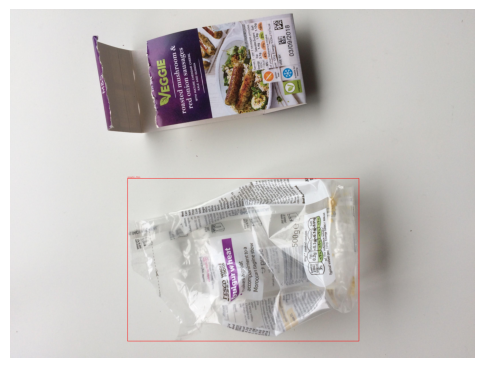

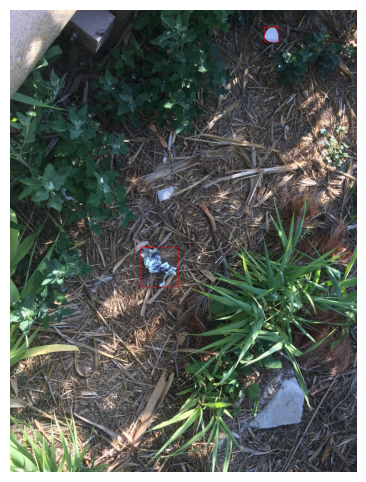

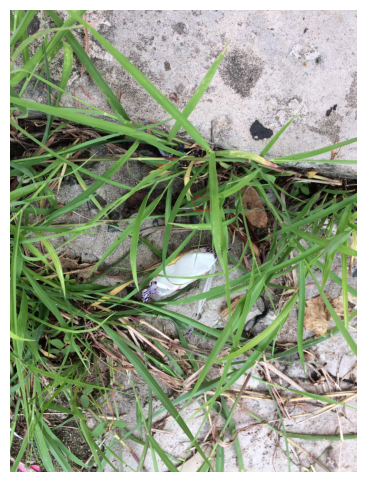

In [14]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

train_i = REPO_ROOT / "data" / "processed" / "images" / "train"
train_l = REPO_ROOT / "data" / "processed" / "labels" / "train"
names   = [l.strip() for l in NAMES_TXT.read_text().splitlines() if l.strip()]

samples = random.sample([p for p in train_i.glob("*") if p.suffix.lower() in IMG_EXTS], k=min(3, len(list(train_i.glob('*')))))

def draw_yolo(img_path: Path):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    lbl_path = train_l / (img_path.with_suffix(".txt").name)
    if lbl_path.exists():
        for line in lbl_path.read_text().splitlines():
            if not line.strip(): continue
            cls, xc, yc, bw, bh = line.split()
            cls = int(cls); xc=float(xc); yc=float(yc); bw=float(bw); bh=float(bh)
            x = int((xc - bw/2) * w); y = int((yc - bh/2) * h)
            x2 = int((xc + bw/2) * w); y2 = int((yc + bh/2) * h)
            cv2.rectangle(img, (x,y), (x2,y2), (255,0,0), 2)
            cv2.putText(img, names[cls] if cls < len(names) else str(cls), (x, max(12,y-4)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)
    plt.figure(figsize=(6,6)); plt.imshow(img); plt.axis("off"); plt.show()

for s in samples:
    draw_yolo(s)


In [9]:
from pathlib import Path
import yaml

# verify yaml vs names.txt
names_txt = Path("../data/processed/names.txt").read_text().splitlines()
with open("../data/recycle.yaml") as f:
    y = yaml.safe_load(f)
assert y["names"] == names_txt, "YAML names and names.txt differ!"
assert y["nc"] == len(names_txt), "nc does not match number of names"

# verify label indices are within range
bad = []
for p in Path("../data/processed/labels/train").rglob("*.txt"):
    for line in p.read_text().splitlines():
        if line.strip():
            idx = int(line.split()[0])
            if not (0 <= idx < len(names_txt)):
                bad.append((p, line))
len(bad), bad[:5]


(0, [])

In [12]:
import collections
names = [l.strip() for l in Path("../data/processed/names.txt").read_text().splitlines()]
cnt = collections.Counter()
for p in Path("../data/processed/labels/train").rglob("*.txt"):
    for ln in p.read_text().splitlines():
        if ln.strip():
            cnt[int(ln.split()[0])] += 1
print({names[k]: v for k,v in cnt.items()})
# need at least a few hundred boxes per class to start

{'plastic_film': 85, 'metal_can': 23, 'other_plastic': 76, 'plastic_bottle': 83, 'glass_bottle': 18}
